In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import h5py
import glob
import math

import numpy             as np
import matplotlib.pyplot as plt
import tensorflow        as tf

from matplotlib.colors     import LogNorm
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics      import roc_curve, auc

In [2]:
%matplotlib inline

In [3]:
! ls -lrth input_qcd_v2/*.h5
! ls -lrth input_suep_v2/*.h5

-rw-r--r--  1 simranjitsinghchhibra  staff   7.1M May  1 17:50 input_qcd_v2/qcd_gensim_101_0.h5
-rw-r--r--  1 simranjitsinghchhibra  staff   7.3M May  1 17:50 input_qcd_v2/qcd_gensim_101_1.h5
-rw-r--r--  1 simranjitsinghchhibra  staff   7.1M May  1 17:50 input_qcd_v2/qcd_gensim_101_2.h5
-rw-r--r--  1 simranjitsinghchhibra  staff   7.4M May  1 17:50 input_qcd_v2/qcd_gensim_101_3.h5
-rw-r--r--  1 simranjitsinghchhibra  staff   7.2M May  1 17:50 input_qcd_v2/qcd_gensim_101_4.h5
-rw-r--r--  1 simranjitsinghchhibra  staff   7.2M May  1 17:50 input_qcd_v2/qcd_gensim_101_5.h5
-rw-r--r--  1 simranjitsinghchhibra  staff   7.2M May  1 17:50 input_qcd_v2/qcd_gensim_101_6.h5
-rw-r--r--  1 simranjitsinghchhibra  staff   7.3M May  1 17:50 input_qcd_v2/qcd_gensim_101_7.h5
-rw-r--r--  1 simranjitsinghchhibra  staff   7.2M May  1 17:50 input_qcd_v2/qcd_gensim_101_8.h5
-rw-r--r--  1 simranjitsinghchhibra  staff   7.4M May  1 17:50 input_qcd_v2/qcd_gensim_101_9.h5
-rw-r--r--  1 simranjitsinghchhibra  sta

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Dropout, Flatten, Reshape, Lambda, Layer, LeakyReLU
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [5]:
version = "v2_1_oppDiceloss_prelu_relu_repeat_100"
version1 = "v2_1_oppDiceloss_prelu_relu_repeat_100"
if (version == "v2_1_oppDiceloss_prelu_relu_repeat_100"  ): RANGE = 28

#version = "v2_1_modDiceloss_prelu_relu"
#version1 = "v2_1_modDiceloss_prelu_relu"
#if (version == "v2_1_modDiceloss_prelu_relu"  ): RANGE = 28

#version = "v2_1_modDiceloss_prelu_relu"
#version1 = "v2_1_modDiceloss_prelu_relu"
#if (version == "v2_1_modDiceloss_prelu_relu"  ): RANGE = 28

model = tf.keras.models.load_model(version+'/model_'+version1, compile=False)
encoder = tf.keras.models.load_model(version+'/encoder_'+version1, compile=False)
#model.summary()

In [6]:
models = []

for i in range(RANGE):
    models.append(tf.keras.models.load_model(version+'/m%d_'%(i+1)+version1, compile=False))

In [7]:
model.summary()

Model: "functional_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 360, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 120, 128)      3584      
                                                                 
 batch_normalization (BatchN  (None, 96, 120, 128)     512       
 ormalization)                                                   
                                                                 
 p_re_lu (PReLU)             (None, 96, 120, 128)      1474560   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 60, 64)        73792     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 60, 64)       256       
 hNormalization)                                      

In [25]:
def images(inputpath, nevts):
    ImageTrk = np.array([])
    ImageECAL = np.array([])
    ImageHCAL = np.array([])

    for fileIN in glob.glob(inputpath):
        print("Appending %s" %fileIN)
        f = h5py.File(fileIN, 'r')

        if (ImageTrk.shape[0] > nevts): break

        myImageTrk  = np.array(f.get("ImageTrk_PUcorr")[:nevts], dtype=np.float32)
        ImageTrk    = np.concatenate([ImageTrk, myImageTrk], axis=0) if ImageTrk.size else myImageTrk

        myImageECAL = np.array(f.get("ImageECAL")[:nevts], dtype=np.float32)
        ImageECAL    = np.concatenate([ImageECAL, myImageECAL], axis=0) if ImageECAL.size else myImageECAL

        myImageHCAL = np.array(f.get("ImageHCAL")[:nevts], dtype=np.float32)
        ImageHCAL    = np.concatenate([ImageHCAL, myImageHCAL], axis=0) if ImageHCAL.size else myImageHCAL

        del myImageTrk, myImageECAL, myImageHCAL

    ImageTrk  = ImageTrk.reshape(ImageTrk.shape[0], ImageTrk.shape[1], ImageTrk.shape[2], 1)
    ImageECAL = ImageECAL.reshape(ImageECAL.shape[0], ImageECAL.shape[1], ImageECAL.shape[2], 1)
    ImageHCAL = ImageHCAL.reshape(ImageHCAL.shape[0], ImageHCAL.shape[1], ImageHCAL.shape[2], 1)

    Image3D = np.concatenate([ImageTrk, ImageECAL, ImageHCAL], axis=-1)

    del ImageTrk, ImageECAL, ImageHCAL

    return Image3D

In [32]:
Image3D_QCD = images("input_qcd_v2/qcd_gensim_101_0*.h5", 10)
#Image3D_QCD = images("input_suep_v2/suep_gensim_h1000_phi2_dp0p7_dt2_101_0*.h5", 20)
print("Image3D.shape ", Image3D_QCD.shape)

Appending input_qcd_v2/qcd_gensim_101_0.h5
Image3D.shape  (10, 286, 360, 3)


In [33]:
Image3D_QCD_zero = np.zeros((Image3D_QCD.shape[0], 288, 360, 3), dtype=np.float16)
Image3D_QCD_zero[:, 1:287, :, :] += Image3D_QCD

print(Image3D_QCD_zero[np.nonzero(Image3D_QCD_zero)])

[0.08057 0.08057 0.08057 ... 0.965   0.67    0.4512 ]


In [34]:
Image3D_QCD_zero = np.divide(Image3D_QCD_zero, 2000., dtype=np.float16)
print(Image3D_QCD_zero.shape)

(10, 288, 360, 3)


In [29]:
#Image3D_QCD_zero[Image3D_QCD_zero == 0] = 999
#Image3D_QCD_zero_tmp = Image3D_QCD_zero*2000
print(Image3D_QCD_zero.shape)

print(np.min(Image3D_QCD_zero))
print(np.max(Image3D_QCD_zero))

print(Image3D_QCD_zero[np.nonzero(Image3D_QCD_zero[:])].shape)

(10, 288, 360, 3)
0.0
0.3865
(17231,)


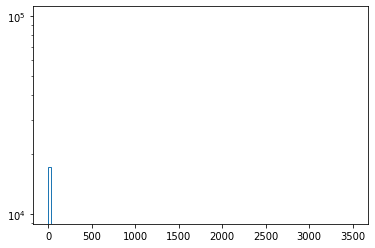

3.23e-05
0.3865


In [30]:
Image3D_QCD_zero = Image3D_QCD_zero[np.nonzero(Image3D_QCD_zero)]
plt.figure()
#plt.hist(Image3D_QCD_zero_1, histtype='step', bins=1000, range=(np.min(Image3D_QCD_zero_1), np.max(Image3D_QCD_zero_1)))
plt.hist(Image3D_QCD_zero, histtype='step', bins=100, range=(np.min(Image3D_QCD_zero), 3500))
plt.semilogy()
plt.show()

print(np.min(Image3D_QCD_zero))
print(np.max(Image3D_QCD_zero))

SUM_Image  (288, 360) 0.0 0.02028
min E 0.0
max E 0.02028
total E 0.1414


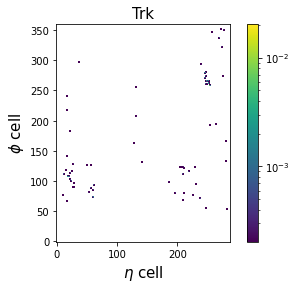

SUM_Image  (288, 360) 0.0 0.01282
min E 0.0
max E 0.01282
total E 0.1605


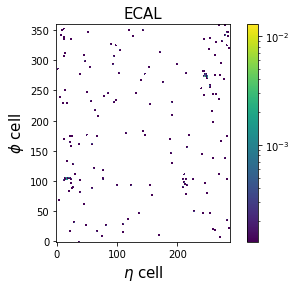

SUM_Image  (288, 360) 0.0 0.0006704
min E 0.0
max E 0.0006704
total E 0.2155


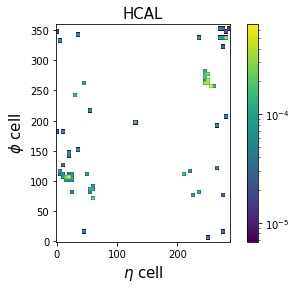

In [35]:
labelCat = ['Trk', 'ECAL', 'HCAL']
for i in range(3):
    Image3D_QCD_zero_tmp = Image3D_QCD_zero*1#2000
    #Image3D_QCD_zero_tmp[Image3D_QCD_zero_tmp == 0] = 1e-6   
    SUM_Image = np.sum(Image3D_QCD_zero_tmp[:1,:,:,i], axis = 0)
    print("SUM_Image ", SUM_Image.shape, np.min(SUM_Image), np.max(SUM_Image))
        
    print("min E", np.min(SUM_Image))
    print("max E", np.max(SUM_Image))
    print("total E", np.sum(np.sum(SUM_Image, axis = 1), axis = 0))

    if (np.max(SUM_Image) <= 1): 
        plt.imshow(SUM_Image.T, origin='lower', norm=LogNorm(vmin=np.max(SUM_Image)*0.01))
    elif(np.min(SUM_Image) == 0): 
        plt.imshow(SUM_Image.T, origin='lower', norm=LogNorm(vmin=0.1))
    elif(np.min(SUM_Image) <  0 or np.max(SUM_Image) > 1): 
        plt.imshow(SUM_Image.T, origin='lower', vmin=np.min(SUM_Image), vmax=np.max(SUM_Image))
        
    plt.colorbar()
    plt.title(labelCat[i], fontsize=15)
    plt.xlabel("$\eta$ cell", fontsize=15)
    plt.ylabel("$\phi$ cell", fontsize=15)
    #if (i == 2): 
    plt.savefig(labelCat[i]+'_QCD_event1_qcd_gensim_101_0.pdf', dpi=1000)
    #plt.savefig(labelCat[i]+'_SUEP_event11_suep_gensim_h1000_phi2_dp0p7_dt2_101_0.pdf', dpi=1000)
    plt.show()

(10, 288, 360, 3)
min E 0.0
max E 0.02405
total E 0.517


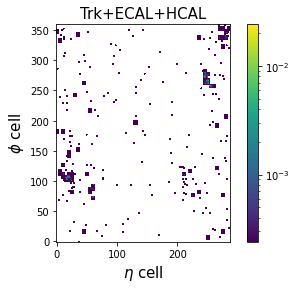

In [36]:
print(Image3D_QCD_zero.shape)

for i in range(1):
    Image3D_QCD_zero_tmp = Image3D_QCD_zero*1#2000
    #Image3D_QCD_zero_tmp[Image3D_QCD_zero_tmp<0.5] = 1
        
    SUM_Image = np.sum(Image3D_QCD_zero_tmp[:1,:,:,:], axis = 0)
    SUM_Image = np.sum(SUM_Image, axis = -1)
    
    print("min E", np.min(SUM_Image))
    print("max E", np.max(SUM_Image))
    print("total E", np.sum(np.sum(SUM_Image, axis = 1), axis = 0))
    
    if (np.max(SUM_Image) <= 1): 
        plt.imshow(SUM_Image.T, origin='lower', norm=LogNorm(vmin=np.max(SUM_Image)*0.01))
    elif(np.min(SUM_Image) == 0): 
        plt.imshow(SUM_Image.T, origin='lower', norm=LogNorm(vmin=0.1))
    elif(np.min(SUM_Image) <  0 or np.max(SUM_Image) > 1): 
        plt.imshow(SUM_Image.T, origin='lower', vmin=np.min(SUM_Image), vmax=np.max(SUM_Image))

    plt.colorbar()
    plt.title("Trk+ECAL+HCAL", fontsize=15)
    plt.xlabel("$\eta$ cell", fontsize=15)
    plt.ylabel("$\phi$ cell", fontsize=15)
    plt.savefig("3channels_QCD_event1_qcd_gensim_101_0.pdf", dpi=1000)
    #plt.savefig("3channels_SUEP_event11_suep_gensim_h1000_phi2_dp0p7_dt2_101_0.pdf", dpi=1000)
    plt.show()

In [40]:
predictedQCD = model.predict(Image3D_QCD_zero[:10])
predictedQCD_encoder = encoder.predict(Image3D_QCD_zero[:10])#[2]

print(predictedQCD.shape)

(10, 288, 360, 3)


In [18]:
predictedQCD = predictedQCD.sum(-1)
predictedQCD = predictedQCD.sum(-1)
predictedQCD = predictedQCD.sum(-1)

print(predictedQCD.shape)

(10,)


In [19]:
print(predictedQCD.shape)

print(predictedQCD[9])

(10,)


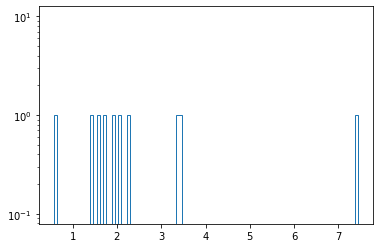

In [20]:
plt.figure()
plt.hist(predictedQCD, histtype='step', bins=100)#, range=(np.min(Image3D_QCD_zero), 300000))
plt.semilogy()
plt.show()

In [41]:
predictedQCD_m = []
for i in range(RANGE):
    predictedQCD_m.append(models[i].predict(Image3D_QCD_zero[:10]))

ae SUM_Image  (288, 360) 0.0 0.011202417
min E 0.0
max E 0.011202417
total E 0.57825494


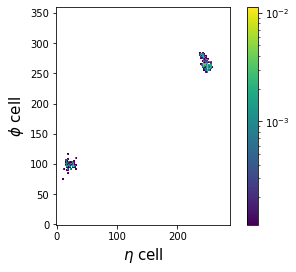

In [42]:
for i in range(1):
    #name = "m%d"%(i+1)
    name = "ae"
    #name = "encoder"
    SUM_Image = np.sum(predictedQCD[:1,:,:,:], axis = 0)
    SUM_Image = np.sum(SUM_Image, axis = -1)

    print(name+" SUM_Image ", SUM_Image.shape, np.min(SUM_Image), np.max(SUM_Image))
    print("min E", np.min(SUM_Image))
    print("max E", np.max(SUM_Image))
    print("total E", np.sum(np.sum(SUM_Image, axis = 1), axis = 0))

    plt.figure()
    if (name == "ae" or name == "encoder"): 
        #plt.imshow(SUM_Image.T, origin='lower', norm=LogNorm(vmin=0.1))
        if (np.max(SUM_Image) <= 1): 
            plt.imshow(SUM_Image.T, origin='lower', norm=LogNorm(vmin=np.max(SUM_Image)*0.01))
        elif(np.min(SUM_Image) == 0):
            plt.imshow(SUM_Image.T, origin='lower', norm=LogNorm(vmin=0.1))
        elif(np.min(SUM_Image) <  0 or np.max(SUM_Image) > 1): 
            plt.imshow(SUM_Image.T, origin='lower', vmin=np.min(SUM_Image), vmax=np.max(SUM_Image))

    else: plt.imshow(SUM_Image.T, origin='lower', vmin=np.min(SUM_Image), vmax=np.max(SUM_Image))

    plt.colorbar()
    #plt.title("Trk+ECAL+HCAL", fontsize=15)
    plt.xlabel("$\eta$ cell", fontsize=15)
    plt.ylabel("$\phi$ cell", fontsize=15)
    plt.savefig('predictedQCD_'+name+'_event1_qcd_gensim_101_0.pdf', dpi=1000)
    #plt.savefig('predictedSUEP_'+name+'_event11_suep_gensim_h1000_phi2_dp0p7_dt2_101_0.pdf', dpi=1000)
    #plt.show()

In [43]:
def mse(data_in, data_out):
    mse = (data_out-data_in)*(data_out-data_in)
    
    index_0 = mse.shape[0]
    index_1 = mse.shape[1]
    index_2 = mse.shape[2]
    index_3 = mse.shape[3]

    mse = mse.sum(-1)
    mse = mse.sum(-1)
    mse = mse.sum(-1)
    mse = mse.sum(0)
    mse /= (index_0*index_1*index_2*index_3)
    return mse

In [44]:
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [0,1,2,3])

In [46]:
lossQCD = mse(Image3D_QCD_zero[:2], predictedQCD[:2])

print(lossQCD)

1.0185279028773799e-06


In [47]:
lossQCD = r_loss(Image3D_QCD_zero[:2], predictedQCD[:2])

print(lossQCD)

tf.Tensor(1.018528e-06, shape=(), dtype=float32)


In [48]:
mse_tmp = tf.keras.losses.MeanSquaredError()
print(mse_tmp(Image3D_QCD_zero[:2], predictedQCD[:2]).numpy())

1.0185278e-06


In [ ]:
from sklearn.metrics import roc_curve, auc

def sumall(data_in):
    index_1 = data_in.shape[1]
    index_2 = data_in.shape[2]
    index_3 = data_in.shape[3]

    data_in = data_in.sum(-1)
    data_in = data_in.sum(-1)
    data_in = data_in.sum(-1)
    #data_in /= (index_1*index_2*index_3)
    return data_in
    
i = 3

#names = ["loss_suep125", "predicted_suep125", "true_suep125", "Encoder_suep125"]
names = ["loss_suep1000", "predicted_suep1000", "true_suep1000", "predicted_encoder_suep1000"]

if (i == 0): pQCD = lossQCD
if (i == 1): pQCD = sumall(predictedQCD)
if (i == 2): pQCD = sumall(Image3D_QCD_zero) #(2000, 2, 5, 2) #[:,1:2,*:*,0:1]
if (i == 3): pQCD = np.sum(np.sum(np.sum(predictedQCD_encoder[:,1:2,0:1,0:1], axis=-1), axis=-1), axis=-1)
#if (i == 3): pQCD = sumall(predictedQCD_encoder)
print(pQCD.shape)

if (i == 0): pSUEP = lossSUEP
if (i == 1): pSUEP = sumall(predictedSUEP)
if (i == 2): pSUEP  = sumall(Image3D_SUEP_zero)
if (i == 3): pSUEP = np.sum(np.sum(np.sum(predictedSUEP_encoder[:,1:2,0:1,0:1], axis=-1), axis=-1), axis=-1)
#if (i == 3): pSUEP = sumall(predictedSUEP_encoder)
print(pSUEP.shape)

print(np.max(pSUEP))
print(np.max(pQCD))

maxScore = np.max(pQCD)
minScore = np.min(pQCD)
plt.hist(pQCD, bins=100, label='QCD', density=True,# range=(minScore, maxScore), 
         histtype='step', fill=False)
plt.hist(pSUEP, bins=100, label='SUEP', density=True,# range=(minScore, maxScore), 
         histtype='step', fill=False)
plt.semilogy()
if (i == 0): plt.xlabel("AE Loss")
if (i == 1): plt.xlabel("Predicted E")
if (i == 2): plt.xlabel("True E")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.savefig("compare_"+names[i]+".pdf",dpi=1000)
plt.show()

targetSUEP = np.ones(pSUEP.shape[0])
targetQCD  = np.zeros(pQCD.shape[0])
trueVal = np.concatenate((targetSUEP, targetQCD))
predVal = np.concatenate((pSUEP, pQCD))

del pSUEP, pQCD, targetSUEP, targetQCD
fpr, tpr, threshold = roc_curve(trueVal, predVal)
auc = auc(fpr, tpr)

plt.figure()
plt.plot(tpr,fpr,label='SUEP Anomaly Detection, auc = %0.1f%%'%(auc*100.))
plt.xlabel("sig. efficiency (TPR)")
plt.ylabel("bkg. mistag rate (FPR)")
#plt.yscale('log')
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig("roc_"+names[i]+".pdf",dpi=1000)
plt.show()

del tpr, fpr, auc

In [50]:
hf = h5py.File('plots_suep1000_v2_1_oppDiceloss_prelu_relu_repeat_100/data.h5', 'r')
print(hf.keys())

<KeysViewHDF5 ['fpr_AE_loss', 'fpr_invpt', 'fpr_pt', 'fpr_truept', 'tpr_AE_loss', 'tpr_intpt', 'tpr_pt', 'tpr_truept']>


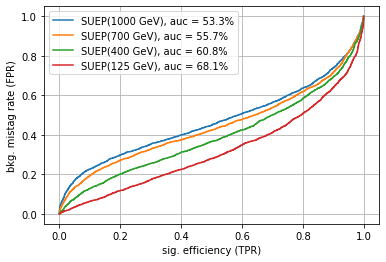

In [51]:
#! ls -lrt plots*_100
hf = h5py.File('plots_suep1000_v2_1_oppDiceloss_prelu_relu_repeat_100/data.h5', 'r')
hf.keys()
#tpr_1000 = hf.get('tpr_AE_loss')
#fpr_1000 = hf.get('fpr_AE_loss')
#tpr_1000 = hf.get('tpr_intpt')
#fpr_1000 = hf.get('fpr_invpt')
tpr_1000 = hf.get('tpr_truept')
fpr_1000 = hf.get('fpr_truept')
auc_1000 = auc(fpr_1000, tpr_1000)

hf = h5py.File('plots_suep700_v2_1_oppDiceloss_prelu_relu_repeat_100/data.h5', 'r')
#tpr_700 = hf.get('tpr_AE_loss')
#fpr_700 = hf.get('fpr_AE_loss')
#tpr_700 = hf.get('tpr_intpt')
#fpr_700 = hf.get('fpr_invpt')
tpr_700 = hf.get('tpr_truept')
fpr_700 = hf.get('fpr_truept')
auc_700 = auc(fpr_700, tpr_700)

hf = h5py.File('plots_suep400_v2_1_oppDiceloss_prelu_relu_repeat_100/data.h5', 'r')
#tpr_400 = hf.get('tpr_AE_loss')
#fpr_400 = hf.get('fpr_AE_loss')
#tpr_400 = hf.get('tpr_intpt')
#fpr_400 = hf.get('fpr_invpt')
tpr_400 = hf.get('tpr_truept')
fpr_400 = hf.get('fpr_truept')
auc_400 = auc(fpr_400, tpr_400)

hf = h5py.File('plots_suep125_v2_1_oppDiceloss_prelu_relu_repeat_100/data.h5', 'r')
#tpr_125 = hf.get('tpr_AE_loss')
#fpr_125 = hf.get('fpr_AE_loss')
#tpr_125 = hf.get('tpr_intpt')
#fpr_125 = hf.get('fpr_invpt')
tpr_125 = hf.get('tpr_truept')
fpr_125 = hf.get('fpr_truept')
auc_125 = auc(fpr_125, tpr_125)

plt.figure()
plt.xlabel("sig. efficiency (TPR)")
plt.ylabel("bkg. mistag rate (FPR)")
plt.plot(tpr_1000[:],fpr_1000[:],label='SUEP(1000 GeV), auc = %0.1f%%'%(auc_1000*100.))
plt.plot(tpr_700[:],fpr_700[:],label='SUEP(700 GeV), auc = %0.1f%%'%(auc_700*100.))
plt.plot(tpr_400[:],fpr_400[:],label='SUEP(400 GeV), auc = %0.1f%%'%(auc_400*100.))
plt.plot(tpr_125[:],fpr_125[:],label='SUEP(125 GeV), auc = %0.1f%%'%(auc_125*100.))
#plt.yscale('log')
plt.grid(True)
plt.legend(loc='upper left')
#plt.legend(loc='lower right')
#plt.savefig("roc_AEloss_log.pdf",dpi=1000)
plt.savefig("roc_invE.pdf",dpi=1000)
plt.show()

In [52]:
###### print(tpr_1000[584:585])
#print(fpr_1000[584:585])
print(tpr_1000[152:153])
print(fpr_1000[152:153])

#print(tpr_700[706:707])
#print(fpr_700[706:707])
print(tpr_700[218:219])
print(fpr_700[218:219])

#print(tpr_400[926:927])
#print(fpr_400[926:927])
print(tpr_400[377:378])
print(fpr_400[377:378])

#print(tpr_125[925:926])
#print(fpr_125[925:926])
print(tpr_125[723:724])
print(fpr_125[723:724])

[0.02525]
[0.11725]
[0.04]
[0.118]
[0.08925]
[0.1195]
[0.2615]
[0.14975]


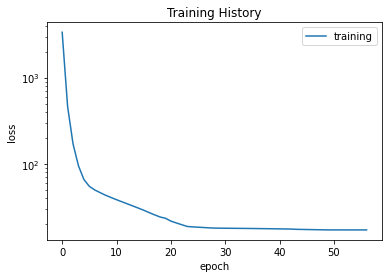

In [53]:
history = np.load('v2_1_oppDiceloss_prelu_relu_repeat_100/history_v2_1_oppDiceloss_prelu_relu_repeat_100.npy', allow_pickle='TRUE').item()

plt.plot(history['loss'])
#plt.plot(history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.xlim([-1, 20])
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig('v2_1_oppDiceloss_prelu_relu_repeat_100.pdf', dpi=1000)
plt.show()


Found 202599 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


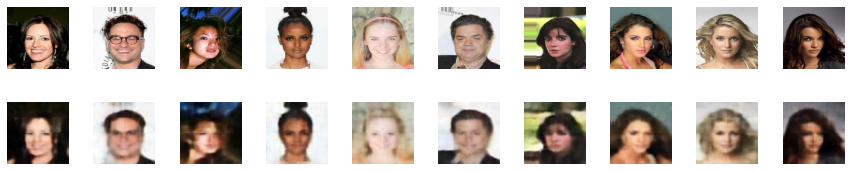

In [55]:
version = "v1_1_kaggle_modifiedloss"

simple_autoencoder = tf.keras.models.load_model(version+'/model_'+version, compile=False)
encoder = tf.keras.models.load_model(version+'/encoder_'+version, compile=False)

from keras.preprocessing.image import ImageDataGenerator

INPUT_DIM = (128,128,3) # Image dimension                                                                                                                                                                   
parts = 128
Z_DIM = 200 # Dimension of the latent vector (z)                                                                                                                                                            

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory('./img_align_celeba/',
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = parts,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training')
import matplotlib.pyplot as plt

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

def plot_compare(images=None, add_noise=False):
    if images is None:
        example_batch = next(data_flow)
        example_batch = example_batch[0]
        images = example_batch[:10]

    n_to_show = images.shape[0]

    if add_noise:
        encodings = encoder.predict(images)
        encodings += np.random.normal(0.0, 1.0, size = (n_to_show,4,4,2))
        reconst_images = decoder.predict(encodings)

    else:
        reconst_images = simple_autoencoder.predict(images)
    
    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)
        
    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img)

plot_compare(example_images)

In [56]:
models = []

for i in range(RANGE):
    models.append(tf.keras.models.load_model(version+'/m%d_'%(i+1)+version, compile=False))

In [57]:
image         = simple_autoencoder.predict(example_images[0:1])
image_encoder = encoder.predict(example_images[0:1])#[2]

image_m = []
for i in range(RANGE):
    image_m.append(models[i].predict(example_images[0:1]))

float32


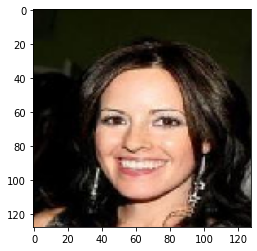

m1


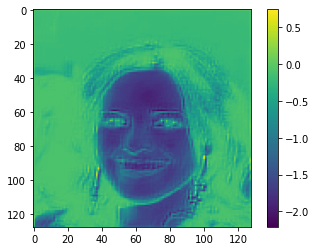

m2


<Figure size 432x288 with 0 Axes>

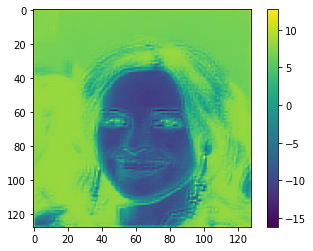

m3


<Figure size 432x288 with 0 Axes>

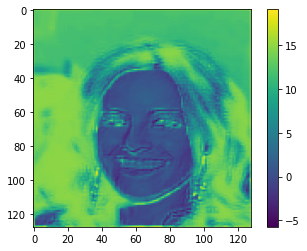

m4


<Figure size 432x288 with 0 Axes>

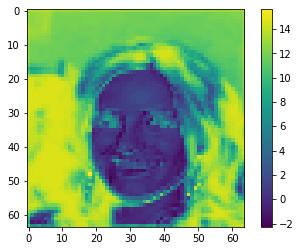

m5


<Figure size 432x288 with 0 Axes>

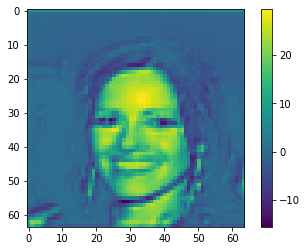

m6


<Figure size 432x288 with 0 Axes>

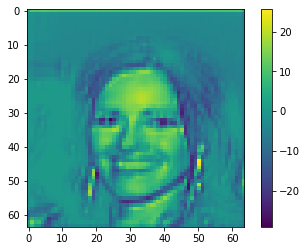

m7


<Figure size 432x288 with 0 Axes>

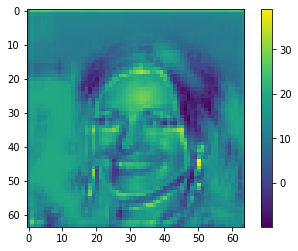

m8


<Figure size 432x288 with 0 Axes>

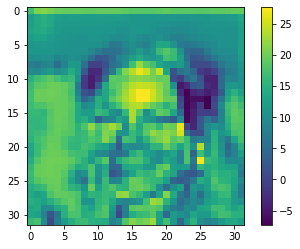

m9


<Figure size 432x288 with 0 Axes>

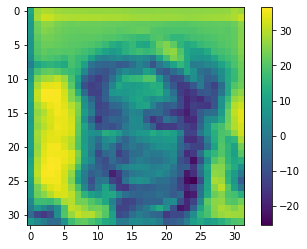

m10


<Figure size 432x288 with 0 Axes>

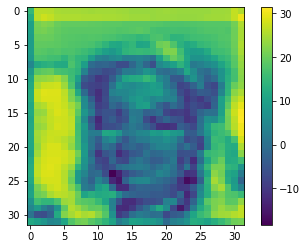

m11


<Figure size 432x288 with 0 Axes>

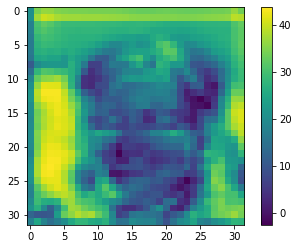

m12


<Figure size 432x288 with 0 Axes>

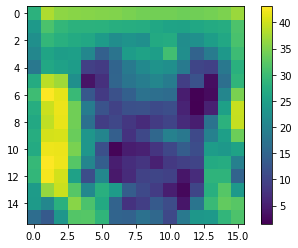

m13


<Figure size 432x288 with 0 Axes>

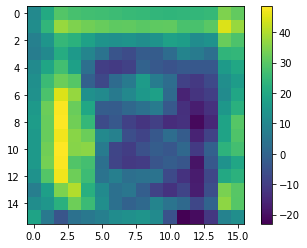

m14


<Figure size 432x288 with 0 Axes>

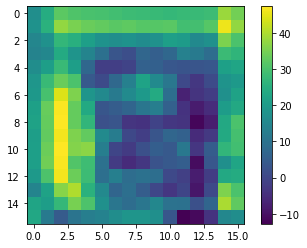

m15


<Figure size 432x288 with 0 Axes>

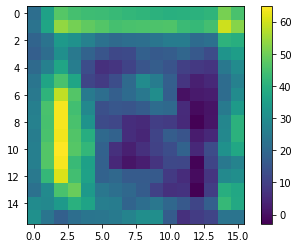

m16


<Figure size 432x288 with 0 Axes>

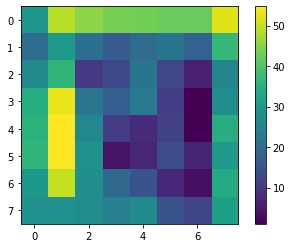

m17


<Figure size 432x288 with 0 Axes>

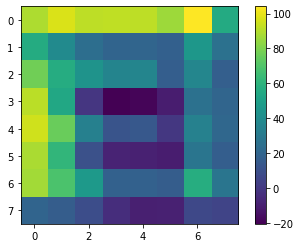

m18


<Figure size 432x288 with 0 Axes>

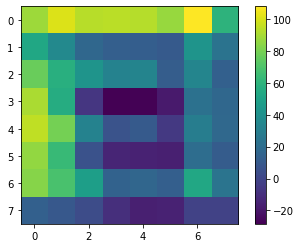

m19


<Figure size 432x288 with 0 Axes>

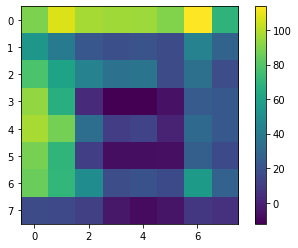

m20


<Figure size 432x288 with 0 Axes>

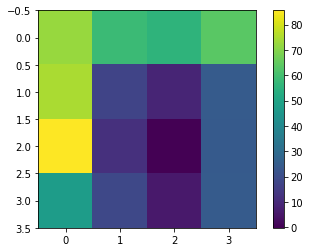

m21


<Figure size 432x288 with 0 Axes>

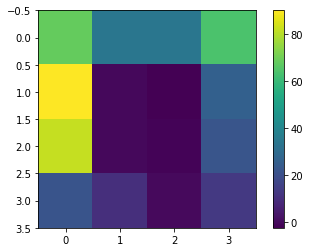

m22


<Figure size 432x288 with 0 Axes>

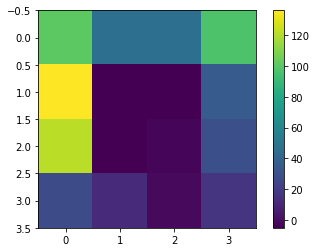

m23


<Figure size 432x288 with 0 Axes>

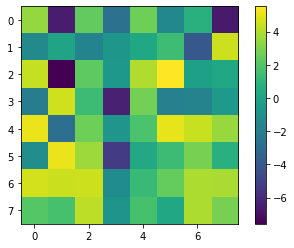

m24


<Figure size 432x288 with 0 Axes>

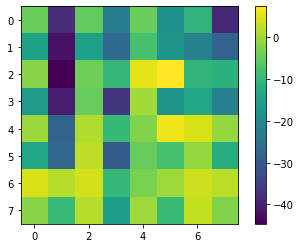

m25


<Figure size 432x288 with 0 Axes>

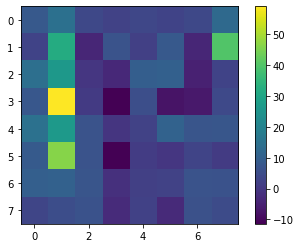

m26


<Figure size 432x288 with 0 Axes>

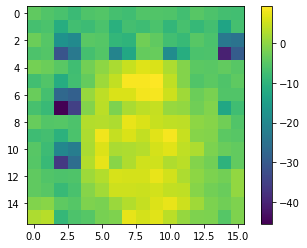

m27


<Figure size 432x288 with 0 Axes>

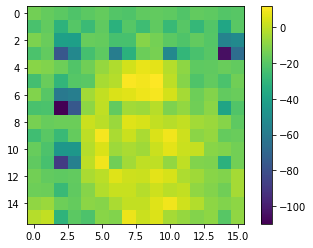

m28


<Figure size 432x288 with 0 Axes>

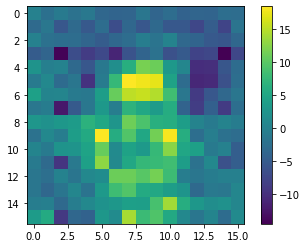

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

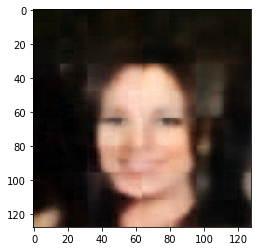

In [58]:
fig = plt.figure()
print(example_images.dtype)
plt.imshow(example_images[0])
plt.show()
    
for i in range(RANGE):
    name = "m%d"%(i+1)
    print(name)
    fig = plt.figure()
    img = np.sum(np.sum(image_m[i], axis=0), axis=-1, dtype='float32')
    plt.imshow(img)
    plt.colorbar()
    plt.show()
    plt.savefig('predictedFace_'+name+'.pdf', dpi=1000)

fig = plt.figure()
plt.imshow(image[0])
plt.show()